# 1. Configurations

In [ ]:
# !pip install transformers==4.30.2 loralib==0.1.1 sentencepiece==0.1.99 livelossplot==0.5.5 pycaret[full]==3.0.4 spacy==3.6.0
# !pip install nltk numpy pandas matplotlib seaborn
# !pip install packaging==21.3
# !python -m spacy download en_core_web_sm

In [1]:
import os
from os.path import join, dirname
import random
import warnings
import re

import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm import tqdm, trange
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve

# from pycaret.classification import setup, compare_models, create_model, tune_model, blend_models, evaluate_model, automl, predict_model

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything()

In [3]:
class PATH:
    root   = '/root/court-decision-prediction'
    yaml   = join(root, 'court_decision_prediction/configs.yaml')
    data   = join(root, 'data/open')
    train  = join(data, 'train.csv')
    test   = join(data, 'test.csv')
    sample = join(data, 'sample_submission.csv')
    submit = join(root, 'submission')
    models = join(root, 'models')
os.makedirs(PATH.models, exist_ok=True)

# 2. Load Dataset

In [4]:
train_full_data = pd.read_csv(PATH.train)
test_data       = pd.read_csv(PATH.test)
target          = 'first_party_winner'

# 3. EDA / Preprocessing / Modeling

In [5]:
def append_party_group(data):
    data = data.copy()

    def generate_fn(col):
        len_filter = lambda fn, arr: len(list(filter(fn, arr)))  # get number of elements in arr filtered by fn

        def fn(row):
            party       = row[col]
            party_lower = row[col].lower()

            keywords_usa = ['united states', 'national']
            keywords_gpe = ['city', 'republic', 'region', 'district', 'county']
            keywords_org = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'ltd', 'llp', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department', 'commision']
            keywords_grp = [',', 'et al']

            for keyword in keywords_usa:
                if keyword in party_lower:
                    return 'USA'
            else:
                ents = nlp(party).ents
                labels = [e.label_ for e in ents]
                if ('GPE' in labels) or len_filter(lambda k: k in party_lower, keywords_gpe):
                    return 'GPE'
                elif ('ORG' in labels) or ('NORP' in labels) or len_filter(lambda k: k in party_lower, keywords_org):
                    return 'ORG'
                elif (len(labels) > 1) or len_filter(lambda k: k in party_lower, keywords_grp):
                    return 'GRP'
                else:
                    return 'IND'

        return fn

    for col in ('first_party', 'second_party'):
        data[f'{col}_grp'] = data.apply(generate_fn(col), axis=1)
    return data

def undersampling_grp(data, target):
    data_zero_target = data[data[target] == 0]
    data_one_target  = data[data[target] == 1]
    first_party_grp_int = LabelEncoder().fit_transform(data_one_target['first_party_grp'])
    data_one_target_sample = resample(data_one_target, replace=False, n_samples=len(data_zero_target), stratify=first_party_grp_int)
    data = pd.concat([data_zero_target, data_one_target_sample])
    return data

def preprocess_nlp(data):
    # 전처리 함수 1
    def preprocessing(df, cols, shortword, tokenizer, stopword, lemmatizer):    
        first_party_lst = []
        second_party_lst = []
        facts_lst = []
        for col in cols:
            # 좌우 공백 제거
            df[col] = df[col].str.strip()
            # 두 칸 이상의 공백 한 칸으로 변경
            df[col] = df[col].str.replace('  ', ' ')
            # 소문자로 변경
            df[col] = df[col].str.lower()
            # ",", "." 제거
            df[col] = df[col].str.replace(',','')
            df[col] = df[col].str.replace('.','')

            if col == 'first_party':
                for sample in df[col]:
                    # 한글자 단어 제거
                    sample = shortword.sub('', sample)
                    # 특수문자 제거
                    sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                    # tokenzier를 이용한 단어 토큰화
                    token = tokenizer.tokenize(sample)
                    # 불용어 제거
                    new_token = []
                    for tok in token:
                        if tok not in stopword:
                            # 표제어 추출
                            new_token.append(lemmatizer.lemmatize(tok, 'n'))
                    first_party_lst.append(new_token)
                # sklearn.feature_extraction 변환을 위해 단어들을 결합
                for i in range(len(first_party_lst)):
                    first_party_lst[i] = ' '.join(first_party_lst[i])

            elif col == 'second_party':
                for sample in df[col]:
                    # 한글자 단어 제거
                    sample = shortword.sub('', sample)
                    # 특수문자 제거
                    sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                    # tokenzier를 이용한 단어 토큰화
                    token = tokenizer.tokenize(sample)
                    # 불용어 제거
                    new_token = []
                    for tok in token:
                        if tok not in stopword:
                            # 표제어 추출
                            new_token.append(lemmatizer.lemmatize(tok, 'n'))
                    second_party_lst.append(new_token)
                # sklearn.feature_extraction 변환을 위해 단어들을 결합
                for i in range(len(second_party_lst)):
                    second_party_lst[i] = ' '.join(second_party_lst[i])

            elif col=='facts':
                for sample in df[col]:
                    # 한글자 단어 제거
                    sample = shortword.sub('', sample)
                    # 특수문자 제거
                    sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                    # tokenzier를 이용한 단어 토큰화
                    token = tokenizer.tokenize(sample)
                    # 불용어 제거
                    new_token = []
                    for tok in token:
                        if tok not in stopword:
                            new_token.append(tok)
                    facts_lst.append(new_token)
                # sklearn.feature_extraction 변환을 위해 단어들을 결합
                for i in range(len(facts_lst)):
                    facts_lst[i] = ' '.join(facts_lst[i])

            else:
                print('컬럼이름을 변경하지 말아주세요!')

        return first_party_lst, second_party_lst, facts_lst

    # 전처리 함수 2(벡터화)                
    def preprocessing_2(first, second, facts, vec, vec_facts, train=True):
        if train:
            vec.fit(first + second)
            vec_facts.fit(facts)

        X1 = vec.transform(first).toarray()
        X2 = vec.transform(second).toarray()
        X3 = vec_facts.transform(facts).toarray()

        return np.concatenate([X1, X2, X3], axis=1)
    
    # 문자열 전처리 1
    cols       = ['first_party', 'second_party', 'facts']
    shortword  = re.compile(r'\W*\b\w{1}\b')
    tokenizer  = TreebankWordTokenizer()
    stopword   = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    first_train, second_train, facts_train = preprocessing(data, cols, shortword, tokenizer, stopword, lemmatizer)

    # 문자열 전처리 2(벡터화)
    vec       = CountVectorizer(ngram_range=(1, 2))
    vec_facts = TfidfVectorizer(ngram_range=(1, 2))

    X_train = preprocessing_2(first_train, second_train, facts_train, vec, vec_facts)
    y_train = data[target]
    return X_train, y_train

In [24]:
def plot_imbalance(data1, data2, target):
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
    data1[target].plot.hist(ax=ax1),    ax1.set_title(f"{target} (before undersampling)")
    data2[target].plot.hist(ax=ax2), ax2.set_title(f"{target} (after undersampling)")
    plt.show()
    
def plot_grp(data_pp):
#     # 1. Target imbalance
#     _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
#     data[target].plot.hist(ax=ax1),    ax1.set_title(f"{target} (before undersampling)")
#     data_pp[target].plot.hist(ax=ax2), ax2.set_title(f"{target} (after undersampling)")
#     plt.show()
    
    # 2. Party distribution
    def plot_party(ax1, ax2, f):
        data_pp[f].value_counts().head(10).plot.bar(ax=ax1),        ax1.set_title(f"{f} (# unique: {data_pp[f].nunique()})")
        data_pp[f'{f}_grp'].value_counts().plot.bar(ax=ax2, rot=0), ax2.set_title(f"{f}_grp (# unique: {data_pp[f+'_grp'].nunique()})")
    for f in ('first_party', 'second_party'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
        plot_party(ax1, ax2, f)
    plt.show()
    
    # 3. Samples of party group
    for party in ('first_party', 'second_party'):
        party_grp = f"{party}_grp"
        for val in data_pp[party_grp].unique():
            sample = data_pp[data_pp[party_grp] == val].sample(5)
            print(party, val, ':', sample[party].tolist())
    
    # 4. Target mean
    conf = data_pp.pivot_table(index='first_party_grp', columns='second_party_grp', values=target)
    target_mean = conf.values.flatten().mean()
    conf -= target_mean
    
    _, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(conf, annot=True, center=0, cmap='coolwarm', ax=ax)
    ax.set_title("Mean(adj. target) for first_party_grp vs second_party_grp");
    plt.show()
        
    # 5. Histogram of target mean
    median = np.median(conf.values.flatten())
    median_abs = np.median(conf.abs().values.flatten())

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10))
    sns.histplot(conf.values.flatten(), ax=ax1)
    ax1.axvline(median, color='k', label=f'Median={median:.3f}')
    ax1.set_title("Histogram for Mean(adj. target)")
    ax1.legend()

    sns.histplot(conf.abs().values.flatten(), ax=ax2)
    ax2.axvline(median_abs, color='k', label=f'Median={median_abs:.3f}')
    ax2.set_title("Histogram for abs(Mean(adj. target))")
    ax2.legend()
    plt.show()
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax, title):
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax.set_xlabel('Thresholds')
    ax.legend(loc='center left')
    ax.set_ylim([0, 1])
    ax.grid()
    ax.set_title(title)

## 3.1 Grouping party

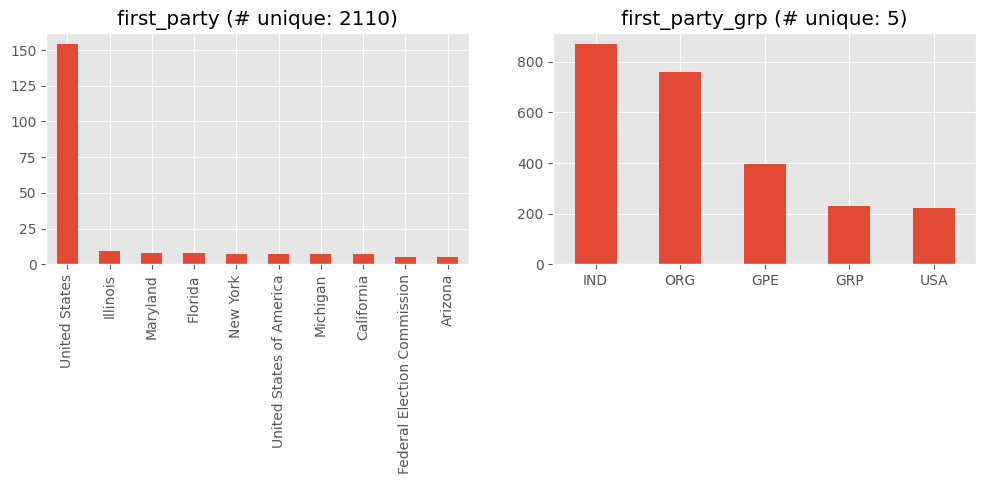

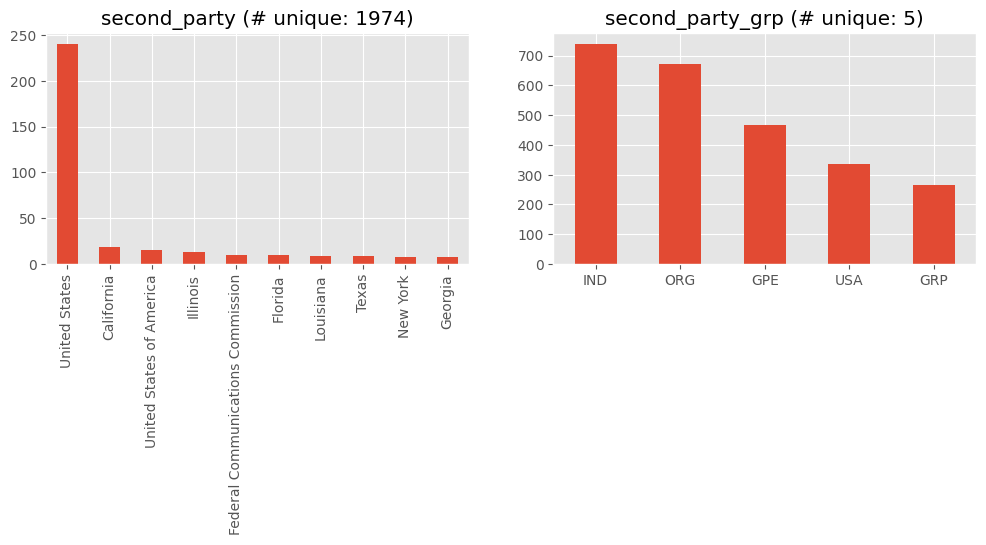

first_party IND : ['Abigail N. Fisher', 'Nathan Jackson', 'Leathers', "O'Gilvie", 'Frank Wilkinson']
first_party ORG : ['Teva Pharmaceuticals USA, Inc.', 'Colorado Department of State', 'Tinker', 'Capital Cities Cable, Inc.', 'Hosanna-Tabor Evangelical Lutheran Church and School']
first_party GRP : ['Alberto R. Gonzales, Attorney General', 'Joseph McKeiver et al.', 'Jan Hamilton, Chapter 13 Trustee', 'Joseph Scheidler et al.', 'Alberto R. Gonzales, Attorney General']
first_party GPE : ['North Carolina', 'City of Renton', 'Board of Education of Central School District No. 1 et al.', 'Wisconsin', 'City of Ontario, California et al.']
first_party USA : ['United States', 'United States', 'United States', 'United States', 'United States']
second_party IND : ['Olson', 'John David Stumpf', 'Denise P. Edwards', 'Gardner', 'Rusk']
second_party GPE : ['State of Arizona', 'Kentucky', 'City of St. Paul', 'Atchison, Topeka & Santa Fe Railway Co., et al.', 'James Humphrey, Dearborn County Prosecutor

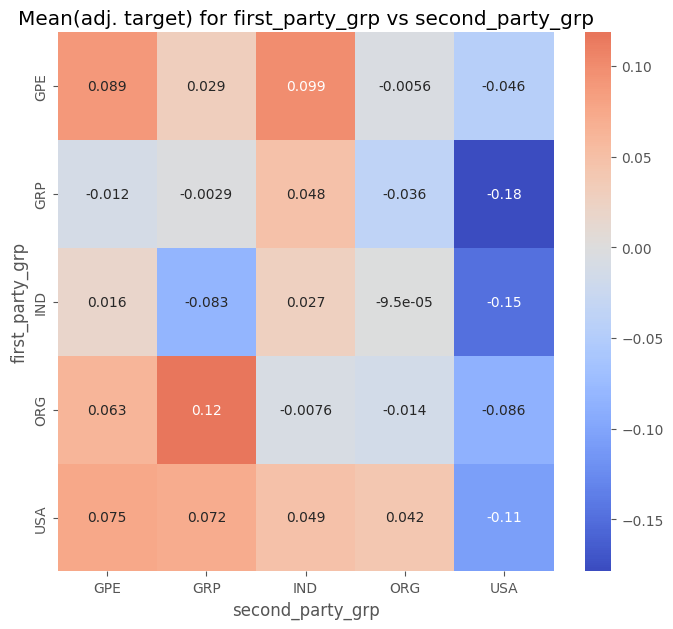

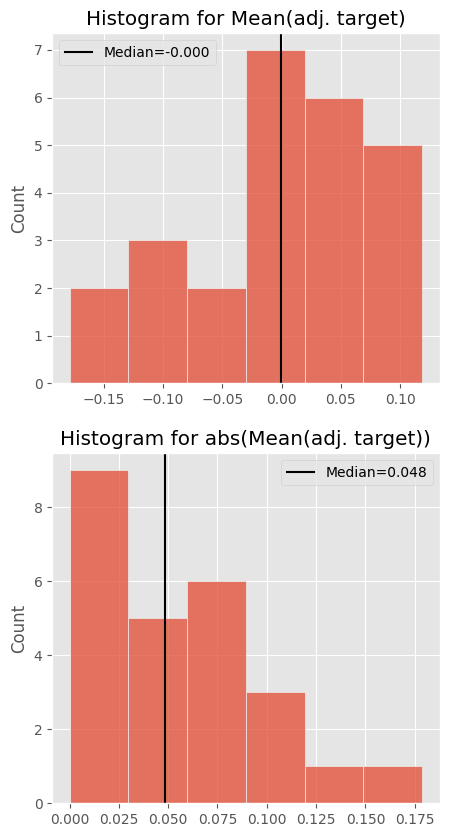

In [7]:
train_full_data_grp = append_party_group(train_full_data)
plot_grp(train_full_data_grp)

In [34]:
fs = train_full_data['facts'].tolist()
f = fs[0]

In [42]:
nlp(f).vector_norm

2.1381500551090005

In [12]:
X_train_full, y_train_full       = pd.get_dummies(train_full_data_grp[['first_party_grp', 'second_party_grp']]), train_full_data_grp[target]
X_train_full_nc, y_train_full_nc = NeighbourhoodCleaningRule(n_neighbors=8).fit_resample(X_train_full, y_train_full)
X_train, X_val, y_train, y_val   = train_test_split(X_train_full_nc, y_train_full_nc, test_size=0.25, stratify=y_train_full_nc)
y_train_full_nc.value_counts()

0    829
1    779
Name: first_party_winner, dtype: int64

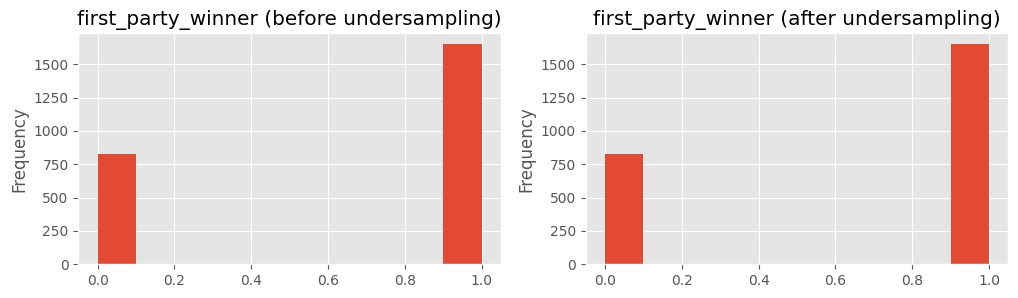

In [16]:
plot_imbalance(train_full_data, train_full_data_grp[[target]], target)

In [17]:
pp = PCA()
model = LogisticRegression().fit(pp.fit_transform(X_train), y_train)
print(classification_report(y_val, model.predict(pp.transform(X_val))))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       207
           1       0.59      0.68      0.63       195

    accuracy                           0.61       402
   macro avg       0.62      0.61      0.61       402
weighted avg       0.62      0.61      0.61       402



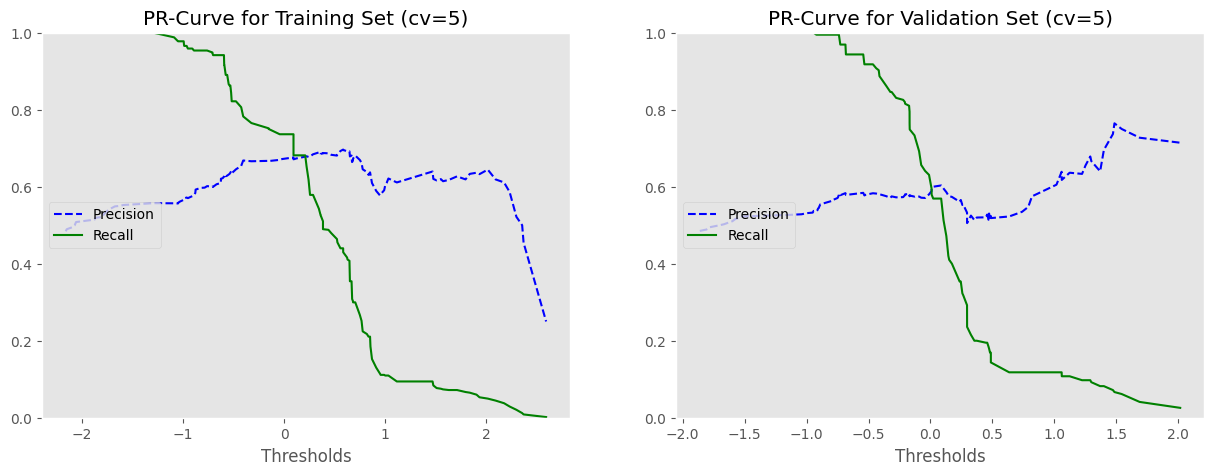

In [33]:
scores_train = cross_val_predict(model, pp.transform(X_train), y_train, cv=5, method='decision_function')
scores_val   = cross_val_predict(model, pp.transform(X_val), y_val, cv=5, method='decision_function')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
precisions, recalls, thresholds = precision_recall_curve(y_train, scores_train)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax1, title='PR-Curve for Training Set (cv=5)')

precisions, recalls, thresholds = precision_recall_curve(y_val, scores_val)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax2, title='PR-Curve for Validation Set (cv=5)')

## 3.2 NLP Preprocessing

In [43]:
X_train_full, y_train_full       = preprocess_nlp(train_full_data)
X_train_full_nc, y_train_full_nc = NeighbourhoodCleaningRule(n_neighbors=3).fit_resample(X_train_full, y_train_full)
X_train, X_val, y_train, y_val   = train_test_split(X_train_full_nc, y_train_full_nc, test_size=0.25, stratify=y_train_full_nc)
y_train_full_nc.value_counts()

0    829
1    813
Name: first_party_winner, dtype: int64

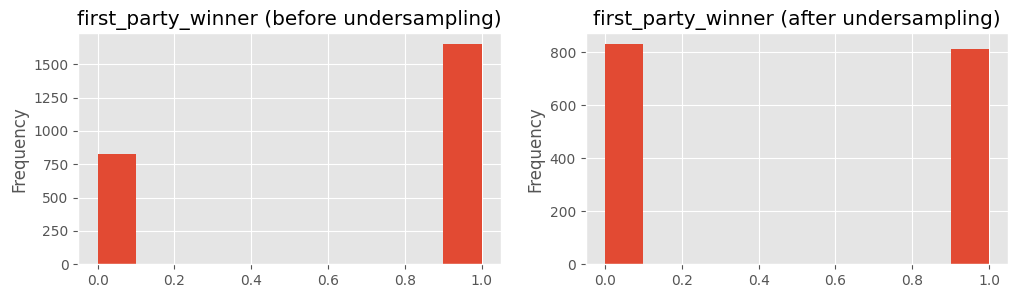

In [46]:
plot_imbalance(train_full_data, y_train_full_nc.to_frame(), target)

In [47]:
pp = PCA()
model = LogisticRegression().fit(pp.fit_transform(X_train), y_train)
print(classification_report(y_val, model.predict(pp.transform(X_val))))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       208
           1       0.68      0.63      0.66       203

    accuracy                           0.67       411
   macro avg       0.67      0.67      0.67       411
weighted avg       0.67      0.67      0.67       411



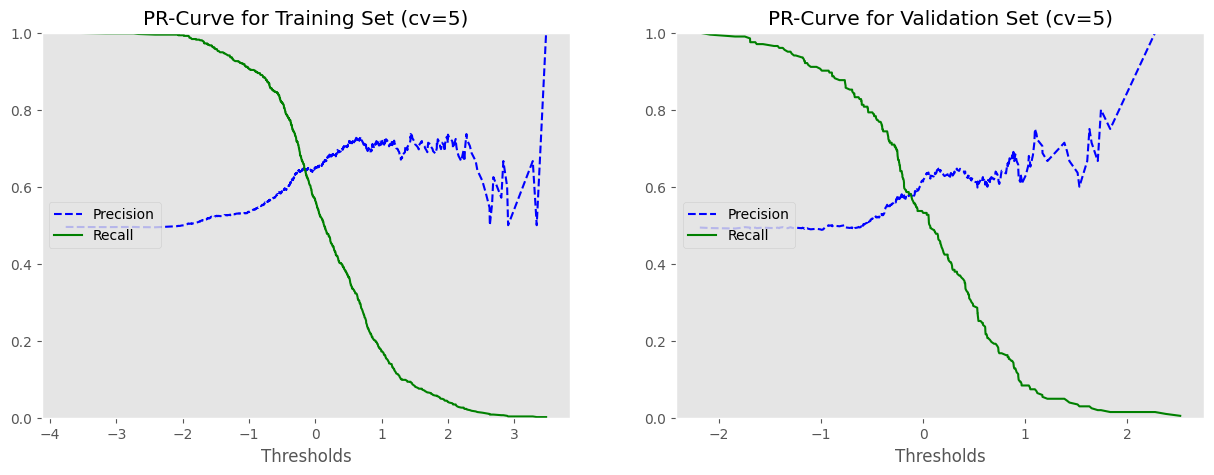

In [49]:
scores_train = cross_val_predict(model, pp.transform(X_train), y_train, cv=5, method='decision_function')
scores_val   = cross_val_predict(model, pp.transform(X_val), y_val, cv=5, method='decision_function')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
precisions, recalls, thresholds = precision_recall_curve(y_train, scores_train)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax1, title='PR-Curve for Training Set (cv=5)')

precisions, recalls, thresholds = precision_recall_curve(y_val, scores_val)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax2, title='PR-Curve for Validation Set (cv=5)')

In [ ]:
a

## 3.3 Ensemble: Grouping party + NLP Preprocessing

In [ ]:
n_zeros = len(train_full_data[train_full_data[target] == 0])
n_valid = n_zeros // 4
idxs_one_valid  = train_full_data[train_full_data[target] == 0].sample(n_valid).index.tolist()
idxs_zero_valid = train_full_data[train_full_data[target] == 1].sample(n_valid).index.tolist()
idxs_valid      = idxs_one_valid + idxs_zero_valid

idxs       = train_full_data.index
train_data = train_full_data.loc[idxs.drop(idxs_valid)]
val_data   = train_full_data.loc[idxs_valid]

In [ ]:
val_data

In [ ]:
# train_data_grp   = append_party_group(train_data)
# val_data_grp     = append_party_group(val_data)

X_train, y_train = pd.get_dummies(train_data_grp[['first_party_grp', 'second_party_grp']]), train_data_grp[[target]]
X_train, y_train = NeighbourhoodCleaningRule(n_neighbors=2).fit_resample(X_train, y_train)
# y_train.value_counts()
X_val, y_val     = pd.get_dummies(val_data_grp[['first_party_grp', 'second_party_grp']]), val_data_grp[[target]]

pp1    = PCA()
model1 = LogisticRegression().fit(pp1.fit_transform(X_train), y_train)
print(classification_report(y_val, model.predict(pp1.transform(X_val))))

In [ ]:
X_train_full, y_train_full = preprocess_nlp(train_full_data)
X_train_full_nc, y_train_full_nc = NeighbourhoodCleaningRule(n_neighbors=3).fit_resample(X_train_full, y_train_full)
X_train, X_val, y_train, y_val = train_test_split(X_train_full_nc, y_train_full_nc, test_size=0.25, stratify=y_train_full_nc)
y_train_full_nc.value_counts()

pp2    = PCA()
model2 = LogisticRegression().fit(pp1.fit_transform(X_train), y_train)
print(classification_report(y_val, model.predict(pp1.transform(X_val))))

---

In [51]:
def get_prompt(row):
    return f"""USER:
- first_party: {row['first_party']} ({row['first_party_grp']})
- second_party: {row['second_party']} ({row['second_party_grp']})
- facts:
{row['facts'][-1000:]:1000}
- Question: Do the first_party win the case? Answer with only 1 or 0. DO NOT ANSWER ANY OTHER WORDS.

ASSISTANT:
- Answer: """

In [55]:
print(get_prompt(train_full_data_grp.iloc[0]))

USER:
- first_party: Phil A. St. Amant (IND)
- second_party: Herman A. Thompson (IND)
- facts:
 Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. 
Thompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather 